Searching for Coincident Data Sets between EMIT and CERES FM6



By Andrew John Buggee

In [1]:
## Import required packages

import requests
import pandas as pd
import datetime as dt
import geopandas as gpd
import matplotlib.pyplot as plt
#from shapely.geometry import MultiPolygon, Polygon, box
from geojson import MultiPolygon, Polygon, Feature, FeatureCollection, dump



In [2]:
# Fixing my CRSERROR
# from functools import partial
# from pyproj import Proj, transform
# proj_4326 = Proj("epsg:4326")
# proj_3857 = Proj("epsg:3857")

In [3]:
## Define the CERES FM6 Concept ID

## Now with the granules found above, we want to see if there is a coincident measurement with the CERES Single Scanner Footprint data product within some alloted time window

# This CERES data is recorded every hour, every day. So to check, we need to determine if any of the individual footprints overlap with EMIT. Therefore we only need the metadata that is within our time window

# # EMIT-NOAA-20
# CERES FM6 SSF L21B, The TOA/Single Scanner Footprint (SSF) product, 
# contains one hour of instantaneous CERES data for a single scanner instrument.
# For info on the CERES-FM6 products, see the link below
# https://ceres.larc.nasa.gov/data/data-product-dois/#noaa20-edition1
doi_ceres = '10.5067/NOAA20/CERES/SSF-FM6_L2.001B'# CERES FM6 on NOAA-20 SSF 

# CMR API base url
cmrurl='https://cmr.earthdata.nasa.gov/search/' 

doisearch = cmrurl + 'collections.json?doi=' + doi_ceres
concept_id_ceres = requests.get(doisearch).json()['feed']['entry'][0]['id']
print(concept_id_ceres)

C2246001744-LARC_ASDC


In [4]:
## Define the EMIT Concept ID

doi_emit = '10.5067/EMIT/EMITL1BRAD.001'# EMIT L1B TOA Radiance

# CMR API base url
cmrurl='https://cmr.earthdata.nasa.gov/search/' 

doisearch = cmrurl + 'collections.json?doi=' + doi_emit
concept_id_emit = requests.get(doisearch).json()['feed']['entry'][0]['id']
print(concept_id_emit)

C2408009906-LPCLOUD


In [5]:
## Create temporal strings used to search for data
# Temporal Bound - Year, month, day. Hour, minutes, and seconds (ZULU) can also be included 
# Let's start by stepping through each day to see if there was EMIT data recorded.

start_date = dt.datetime(2022, 8, 10)
end_date = dt.datetime(2022, 8, 10, 23, 59, 59)  



# Let's create a list of temporal strings that each span 1 day
num_days = [*range(start_date.day,end_date.day+1,1)]              # range(start_value, end_value (not included), step

# CMR formatted start and end times
dt_format = '%Y-%m-%dT%H:%M:%SZ'

temporal_str = [None]*len(num_days)         # define an empty list

for idx, val in enumerate(num_days):
    start_day = dt.datetime(2022, 8, val)
    end_day = dt.datetime(2022, 8, val, 23, 59, 59)
    temporal_str[idx] = start_day.strftime(dt_format) + ',' + end_day.strftime(dt_format)
    
print(temporal_str)

['2022-08-10T00:00:00Z,2022-08-10T23:59:59Z']


In [6]:
## Let's search for EMIT data taken on the day defined by the temporal string above

# By not defining a location but just a temporal constraint, we can find all EMIT files within that time window


page_num = 1
page_size = 2000 # CMR page size limit

granule_arr_emit = []

for idx, val in enumerate(temporal_str):
    # define the day to search
    day2search = temporal_str[idx]

    while True:
    
        # defining parameters
        cmr_param = {
        "collection_concept_id": concept_id_emit, 
        "page_size": page_size,
        "page_num": page_num,
        "temporal": day2search
        }

        granulesearch = cmrurl + 'granules.json'
        response = requests.post(granulesearch, data=cmr_param)
        granules = response.json()['feed']['entry']
       
        if granules:
            for g in granules:
                granule_urls = ''
                granule_poly = ''

                # read cloud cover
                # This is a percentage from 0 to 100
                cloud_cover = g['cloud_cover']
                
                # read in EMIT start time of measurement recording
                time_start = g['time_start']
                # convert time string to a datetime object
                time_start = dt.datetime.strptime(time_start[0:-5] + 'Z', dt_format)
                

                # reading bounding geometries
                if 'polygons' in g:
                    polygons= g['polygons']
                    multipolygons = []
                    for poly in polygons:
                        i=iter(poly[0].split (" "))
                        ltln = list(map(" ".join,zip(i,i)))
                        multipolygons.append(Polygon([[float(p.split(" ")[1]), float(p.split(" ")[0])] for p in ltln]))
                    granule_poly = Polygon(multipolygons)
            
                # Get https URLs to .nc files and exclude .dmrpp files
                granule_urls = [x['href'] for x in g['links'] if 'https' in x['href'] and '.nc' in x['href'] and '.dmrpp' not in x['href']]
                # Add to list
                granule_arr_emit.append([granule_urls, cloud_cover, time_start, granule_poly])

            page_num += 1
        else: 
            break

# Let's check to see if there is anything in the granule
if granule_arr_emit:
    print("Found " + str(len(granule_arr_emit)) + " granule(s) in the time window specified!")
else:
    print("No granules found in the time window specified")

Found 195 granule(s) in the time window specified!


In [7]:
granule_arr_emit[0]

[['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL1BRAD.001/EMIT_L1B_RAD_001_20220810T034103_2222203_001/EMIT_L1B_RAD_001_20220810T034103_2222203_001.nc',
  'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL1BRAD.001/EMIT_L1B_RAD_001_20220810T034103_2222203_001/EMIT_L1B_OBS_001_20220810T034103_2222203_001.nc'],
 '100',
 datetime.datetime(2022, 8, 10, 3, 41, 3),
 {"coordinates": [[[73.694778, 22.390964], [73.154663, 21.768932], [73.731293, 21.26823], [74.271408, 21.890263], [73.694778, 22.390964]]], "type": "Polygon"}]

In [8]:
## Using the times of the EMIT data found above, we can find CERES data. CERES Single scanner footprint data files are written for each hour of the day. 
# The code below will find CERES data belonging to the hour that the start time of the EMIT data


# Now we will search for CERES data
# We will search within a time window defined by the granules above

page_num = 1
page_size = 2000 # CMR page size limit

# Define the time window
time_window = 10                 # minutes

granule_arr_ceres = []

for idx, val in enumerate(granule_arr_emit[0]):
    # define the day to search using the EMIT data timestamps
    start_time_2search = granule_arr_emit[idx][2] - dt.timedelta(minutes=(time_window/2))
    end_time_2search = granule_arr_emit[idx][2] + dt.timedelta(minutes=(time_window/2))
    time2search = dt.datetime.strftime(start_time_2search, dt_format) + ',' + dt.datetime.strftime(end_time_2search, dt_format)

    

    while True:
    
        # defining parameters
        cmr_param = {
        "collection_concept_id": concept_id_ceres, 
        "page_size": page_size,
        "page_num": page_num,
        "temporal": time2search
        }

        granulesearch = cmrurl + 'granules.json'
        response = requests.post(granulesearch, data=cmr_param)
        granules = response.json()['feed']['entry']
        
       
        if granules:
            for g in granules:
                granule_urls = ''
                granule_poly = ''

                
                # read in CERES start time of measurement recording
                time_start = g['time_start']
                # convert time string to a datetime object
                time_start = dt.datetime.strptime(time_start[0:-5] + 'Z', dt_format)
                
                # read in CERES end time of measurement recording
                time_end = g['time_end']
                # convert time string to a datetime object
                time_end = dt.datetime.strptime(time_end[0:-5] + 'Z', dt_format)

                # reading bounding geometries
                if 'polygons' in g:
                    polygons= g['polygons']
                    multipolygons = []
                    for poly in polygons:
                        i=iter(poly[0].split (" "))
                        ltln = list(map(" ".join,zip(i,i)))
                        multipolygons.append(Polygon([[float(p.split(" ")[1]), float(p.split(" ")[0])] for p in ltln]))
                    granule_poly = MultiPolygon(multipolygons)
            
                # Get https URLs to .nc files and exclude .dmrpp files
                granule_urls = [x['href'] for x in g['links'] if 'https' in x['href'] and '.nc' in x['href'] and '.dmrpp' not in x['href']]
                # Add to list
                granule_arr_ceres.append([granule_urls, time_start, time_end, granule_poly])

            page_num += 1
        else: 
            break

            
# Let's check to see if there is anything in the granule
if granule_arr_ceres:
    print("Found " + str(len(granule_arr_ceres)) + " granule(s) in the time window specified!")
else:
    print("No granules found in the time window specified")

Found 1 granule(s) in the time window specified!


In [9]:
print(time2search)

2022-08-10T03:36:39Z,2022-08-10T03:46:39Z


In [10]:
print(granule_arr_ceres)

[[['https://asdc.larc.nasa.gov/data/CERES/SSF/NOAA20-FM6-VIIRS_Edition1B/2022/08/CER_SSF_NOAA20-FM6-VIIRS_Edition1B_100102.2022081003.nc'], datetime.datetime(2022, 8, 10, 3, 0), datetime.datetime(2022, 8, 10, 3, 59, 59), {"coordinates": [[[180.0, -90.0], [180.0, -89.99999], [179.99999, -89.99999], [179.99999, -89.599922], [167.238528, -89.347468], [179.998344, -89.399987], [179.99999, -89.398347], [179.99999, -40.062148], [176.557198, -34.989121], [172.297553, -26.441137], [168.588846, -16.966126], [165.093422, -5.061907], [161.991951, 8.816795], [159.44499, 24.064891], [157.991149, 38.400268], [157.762264, 48.986543], [158.860645, 60.299605], [162.007245, 68.853792], [165.449917, 73.189674], [169.200877, 76.004285], [175.074768, 78.775624], [179.99999, 80.129762], [179.99999, 89.99999], [180.0, 89.99999], [180.0, 90.0], [-180.0, 90.0], [-180.0, 89.99999], [-179.99999, 89.99999], [-179.99999, 80.648307], [-175.994916, 80.359662], [-166.342464, 82.157346], [-156.837664, 82.758574], [-15

In [10]:
## Can we find CERES data using the start time of EMIT AND the polygon of EMIT?

## YES! THE CODE BELOW USING A BOUNDING BOX WORKS! IT IS ABLE TO FIND CERES DATA THAT OVERLAPS WITH THE BOUNDING BOX.
## DOES THIS WORK IF THE BOUNDING BOX OVERLAPS THE BOUNDARY OF THE CERES DATA?
## THIS MEANS WE SHOULD BE ABLE TO FIND CERES DATA BY DEFINING A POLYGON USING THE METADATA FROM EMIT


## Using the times of the EMIT data found above, let's serach for Single Scanner Footprint data that overlaps in time with EMIT


# Now we will search for CERES data
# We will search over the polygon defined from the granule found above
# We will search within a time window defined by the granules above

page_num = 1
page_size = 2000 # CMR page size limit

# Define the time window
time_window = 10                 # minutes

# Search Using a Bounding Box
# first 2 points = bottom left corner of box: (long, lat)
# second 2 points = top right corner of box: (long, lat)
#bound = (140, 82, 145, 85)        # This region works because it overlaps with CERES data
bound = (80, 0, 85, 5)        # This region works because it overlaps with CERES data

bound_str = ','.join(map(str,bound))

granule_arr_ceres = []

for idx, val in enumerate(granule_arr_emit[0]):
    # define the day to search using the EMIT data timestamps
    start_time_2search = granule_arr_emit[idx][2] - dt.timedelta(minutes=(time_window/2))
    end_time_2search = granule_arr_emit[idx][2] + dt.timedelta(minutes=(time_window/2))
    time2search = dt.datetime.strftime(start_time_2search, dt_format) + ',' + dt.datetime.strftime(end_time_2search, dt_format)

    

    while True:
    
        # defining parameters
        cmr_param = {
        "collection_concept_id": concept_id_ceres, 
        "page_size": page_size,
        "page_num": page_num,
        "temporal": time2search,
        "bounding_box[]":bound_str
        }

        granulesearch = cmrurl + 'granules.json'
        response = requests.post(granulesearch, data=cmr_param)
        granules = response.json()['feed']['entry']
        
       
        if granules:
            for g in granules:
                granule_urls = ''
                granule_poly = ''

                
                # read in CERES start time of measurement recording
                time_start = g['time_start']
                # convert time string to a datetime object
                time_start = dt.datetime.strptime(time_start[0:-5] + 'Z', dt_format)
                
                # read in CERES end time of measurement recording
                time_end = g['time_end']
                # convert time string to a datetime object
                time_end = dt.datetime.strptime(time_end[0:-5] + 'Z', dt_format)

                # reading bounding geometries
                if 'polygons' in g:
                    polygons= g['polygons']
                    multipolygons = []
                    for poly in polygons:
                        i=iter(poly[0].split (" "))
                        ltln = list(map(" ".join,zip(i,i)))
                        multipolygons.append(Polygon([[float(p.split(" ")[1]), float(p.split(" ")[0])] for p in ltln]))
                    granule_poly = MultiPolygon(multipolygons)
            
                # Get https URLs to .nc files and exclude .dmrpp files
                granule_urls = [x['href'] for x in g['links'] if 'https' in x['href'] and '.nc' in x['href'] and '.dmrpp' not in x['href']]
                # Add to list
                granule_arr_ceres.append([granule_urls, time_start, time_end, granule_poly])

            page_num += 1
        else: 
            break

            
# Let's check to see if there is anything in the granule
if granule_arr_ceres:
    print("Found " + str(len(granule_arr_ceres)) + " granule(s) in the time window specified!")
else:
    print("No granules found in the time window specified")

No granules found in the time window specified


In [11]:
print(granule_arr_ceres)

[]


In [13]:
df = gpd.GeoDataFrame({'id':[0],'geometry':[polygon]})


In [14]:
geojson = {"shapefile": ("test.geojson", df.geometry.to_json(), "application/geo+json")}



In [14]:
str(polygon)

'{"coordinates": [[[73.694778, 22.390964], [73.154663, 21.768932], [73.731293, 21.26823], [74.271408, 21.890263], [73.694778, 22.390964]]], "type": "Polygon"}'

In [13]:
polygon = granule_arr_emit[0][3]

features = []
features.append(Feature(properties={},  coordinates=polygon))

# add more features...
# features.append(...)

feature_collection = FeatureCollection(features)

with open('test.geojson', 'w') as f:
    dump(feature_collection, f)
    

In [17]:
# Let's write a text file and save it as a geojson

polygon = granule_arr_emit[0][3]

with open('test.geojson', 'w') as f:
    f.write('{"type":"FeatureCollection","features":[{"type":"Feature","properties":{},"geometry":')
    f.write(str(polygon))
    f.write('}]}')

In [22]:
## Can we find CERES data using the start time of EMIT AND the polygon of EMIT?

## Now let's use the polygon shape of the EMIT data to try and find overlapping data between EMIT and CERES


## Using the times of the EMIT data found above, let's serach for Single Scanner Footprint data that overlaps in time with EMIT


page_num = 1
page_size = 2000 # CMR page size limit

# Define the time window
time_window = 10                 # minutes


# polygon = gpd.read_file('isla_gaviota.geojson')
# geojson = {"shapefile": ("isla_gaviota.geojson", polygon.geometry.to_json(), "application/geo+json")}

# store the ceres data
granule_arr_ceres = []
# flag the emit data that is found to have overlap
emit_data_2keep = []

for idx, val in enumerate(granule_arr_emit):
    
    # Write the granule_emit data as a geojson file
    # Let's write a text file and save it as a geojson

    polygon = granule_arr_emit[idx][3]

    with open('emit_FOV.geojson', 'w') as f:
        f.write('{"type":"FeatureCollection","features":[{"type":"Feature","properties":{},"geometry":')
        f.write(str(polygon))
        f.write('}]}')
        
    # Now read in the data as a geojson file
    # Search using a Polygon
    polygon2 = gpd.read_file('test.geojson')
    geojson = {"shapefile": ("test.geojson", polygon2.geometry.to_json(), "application/geo+json")}
    
    # define the day to search using the EMIT data timestamps
    start_time_2search = granule_arr_emit[idx][2] - dt.timedelta(minutes=(time_window/2))
    end_time_2search = granule_arr_emit[idx][2] + dt.timedelta(minutes=(time_window/2))
    time2search = dt.datetime.strftime(start_time_2search, dt_format) + ',' + dt.datetime.strftime(end_time_2search, dt_format)

    

    while True:
    
        # defining parameters
        cmr_param = {
        "collection_concept_id": concept_id_ceres, 
        "page_size": page_size,
        "page_num": page_num,
        "temporal": time2search,
        "simplify-shapefile": 'true' # this is needed to bypass 5000 coordinates limit of CMR
        }

        granulesearch = cmrurl + 'granules.json'
        response = requests.post(granulesearch, data=cmr_param, files=geojson)
        granules = response.json()['feed']['entry']
        
       
        if granules:
            for g in granules:
                granule_urls = ''
                granule_poly = ''

                
                # read in CERES start time of measurement recording
                time_start = g['time_start']
                # convert time string to a datetime object
                time_start = dt.datetime.strptime(time_start[0:-5] + 'Z', dt_format)
                
                # read in CERES end time of measurement recording
                time_end = g['time_end']
                # convert time string to a datetime object
                time_end = dt.datetime.strptime(time_end[0:-5] + 'Z', dt_format)

                # reading bounding geometries
                if 'polygons' in g:
                    polygons= g['polygons']
                    multipolygons = []
                    for poly in polygons:
                        i=iter(poly[0].split (" "))
                        ltln = list(map(" ".join,zip(i,i)))
                        multipolygons.append(Polygon([[float(p.split(" ")[1]), float(p.split(" ")[0])] for p in ltln]))
                    granule_poly = MultiPolygon(multipolygons)
            
                # Get https URLs to .nc files and exclude .dmrpp files
                granule_urls = [x['href'] for x in g['links'] if 'https' in x['href'] and '.nc' in x['href'] and '.dmrpp' not in x['href']]
                # Add to list
                granule_arr_ceres.append([granule_urls, time_start, time_end, granule_poly])
                # flag the EMIT data granule
                emit_data_2keep.append(idx)

            page_num += 1
        else: 
            break

            
# Let's check to see if there is anything in the granule
if granule_arr_ceres:
    print("Found " + str(len(granule_arr_ceres)) + " granule(s) in the time window specified!")
else:
    print("No granules found in the time window specified")

Found 1 granule(s) in the time window specified!


In [23]:
print(granule_arr_ceres)

[[['https://asdc.larc.nasa.gov/data/CERES/SSF/NOAA20-FM6-VIIRS_Edition1B/2022/08/CER_SSF_NOAA20-FM6-VIIRS_Edition1B_100102.2022081008.nc'], datetime.datetime(2022, 8, 10, 8, 0), datetime.datetime(2022, 8, 10, 8, 59, 59), {"coordinates": [[[180.0, -90.0], [180.0, -89.99999], [179.99999, -89.99999], [179.99999, -66.532961], [178.253534, -66.12898], [165.502319, -66.571612], [154.029578, -65.811711], [142.826969, -64.075797], [132.625205, -61.337312], [123.72029, -57.629217], [116.268627, -53.087808], [109.775869, -47.489468], [104.220166, -40.85996], [99.681696, -33.586497], [95.054316, -23.942024], [91.767229, -14.775674], [88.894364, -4.721832], [85.871462, 8.779645], [83.458087, 23.186891], [81.927276, 36.867145], [81.39731, 48.695884], [82.426359, 60.272352], [85.130284, 68.446247], [87.916914, 72.419397], [89.7363, 74.217434], [96.753304, 78.309905], [102.73079, 80.211542], [108.330203, 81.389257], [124.643642, 83.339326], [144.724882, 84.103439], [168.119515, 84.013739], [172.14152

In [28]:
print(granule_arr_emit[103])

[['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL1BRAD.001/EMIT_L1B_RAD_001_20220810T081613_2222206_001/EMIT_L1B_RAD_001_20220810T081613_2222206_001.nc', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL1BRAD.001/EMIT_L1B_RAD_001_20220810T081613_2222206_001/EMIT_L1B_OBS_001_20220810T081613_2222206_001.nc'], '98', datetime.datetime(2022, 8, 10, 8, 16, 13), {"coordinates": [[[-5.093875, 12.532314], [-5.557199, 11.914476], [-4.962781, 11.468716], [-4.499458, 12.086554], [-5.093875, 12.532314]]], "type": "Polygon"}]


In [ ]:
polygon.head()

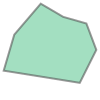

In [45]:
polygon.loc[0, 'geometry']

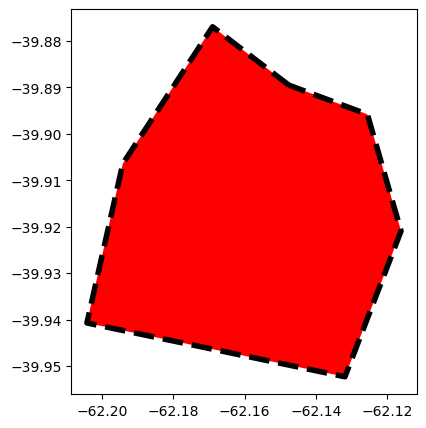

In [59]:

f, ax = plt.subplots(1, figsize=(10, 5))
ax = polygon.plot(ax=ax, marker='.', linestyle='dashed',
                  markersize=12, linewidth=4, edgecolor = 'black',facecolor = 'red')
plt.show()

AttributeError: geoms

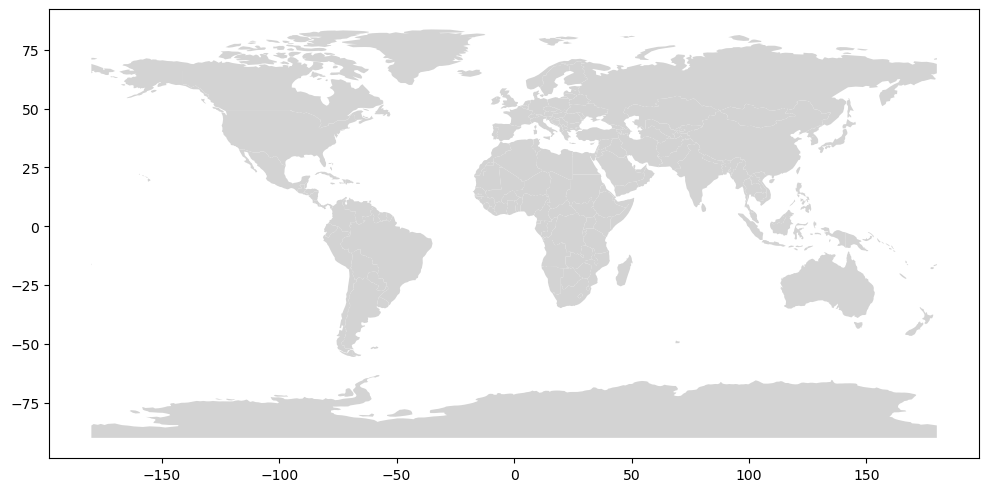

In [62]:
## Let's plot the polygon object!!


# initialize an axis
fig, ax = plt.subplots(figsize=(12,10))
# plot map on axis
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.plot(color="lightgrey",ax=ax)

long,lat = granule_arr_emit[0][len(granule_arr_emit[0])-1].geoms[0].exterior.xy
# for some reason the longitude is the wrong sign
correct_long = [ x for x in long]

# plot points
ax.scatter(correct_long, lat, s = 12, c="blue")

# reduce the view of the plot
# plt.xlim(50, 100)     # set the xlim to left, right
# plt.ylim(15, 30)

# add grid
ax.grid(b=True, alpha=0.5)
plt.show()

In [8]:
test = granule_arr_emit[0][-1]

In [21]:
test.area()

AttributeError: area